- prob 1: remove constant column from securities VVV
- prob 2: create a staightified cv/confirm VVV
- prob 3: tune rf VVV
- prob 4: pca (normalize)? VVV
- prob 5: what lasso decides? VVV
- prob 6: cluster
- prob 7: linear regression

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
adjusted = pd.read_csv('./input/prices-split-adjusted.csv')
fundamentals = pd.read_csv('./input/fundamentals.csv', index_col=0)
securities = pd.read_csv('./input/securities.csv')

In [3]:
len(set(securities['Ticker symbol']) - set(fundamentals['Ticker Symbol']))

57

In [4]:
for col in securities.columns:
    print col, ': ', securities.loc[0, col]

Ticker symbol :  MMM
Security :  3M Company
SEC filings :  reports
GICS Sector :  Industrials
GICS Sub Industry :  Industrial Conglomerates
Address of Headquarters :  St. Paul, Minnesota
Date first added :  nan
CIK :  66740


#### Columns in securities; The columns to be kept: Ticker symbol, GICS Sector

Ticker symbol :  MMM <br>
Security :  3M Company <br>
SEC filings :  reports *Everything is reports; useless*<br>
GICS Sector :  Industrials *Totally 11 sectors* <br>
GICS Sub Industry :  Industrial Conglomerates<br>
Address of Headquarters :  St. Paul, Minnesota<br>
Date first added :  nan<br>
CIK :  66740 **Central Index Key to a company**<br>

**Note**: check out `np.mean(securities.isnull())`, no column we used has missingness
<br><br><br><br><br><br>

---

In [5]:
for col in fundamentals.columns:
    print col, ': ', fundamentals.loc[0, col]

Ticker Symbol :  AAL
Period Ending :  2012-12-31
Accounts Payable :  3068000000.0
Accounts Receivable :  -222000000.0
Add'l income/expense items :  -1961000000.0
After Tax ROE :  23.0
Capital Expenditures :  -1888000000.0
Capital Surplus :  4695000000.0
Cash Ratio :  53.0
Cash and Cash Equivalents :  1330000000.0
Changes in Inventories :  0.0
Common Stocks :  127000000.0
Cost of Revenue :  10499000000.0
Current Ratio :  78.0
Deferred Asset Charges :  0.0
Deferred Liability Charges :  223000000.0
Depreciation :  1001000000.0
Earnings Before Interest and Tax :  -1813000000.0
Earnings Before Tax :  -2445000000.0
Effect of Exchange Rate :  0.0
Equity Earnings/Loss Unconsolidated Subsidiary :  0.0
Fixed Assets :  13402000000.0
Goodwill :  0.0
Gross Margin :  58.0
Gross Profit :  14356000000.0
Income Tax :  -569000000.0
Intangible Assets :  869000000.0
Interest Expense :  632000000.0
Inventory :  580000000.0
Investments :  306000000.0
Liabilities :  473000000.0
Long-Term Debt :  7116000000.0

In [6]:
map(lambda x: fundamentals[x].dtype, fundamentals)

[dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtyp

In [7]:
np.mean(fundamentals.isnull()).sort_values(ascending=False).head(8)

Cash Ratio                                        0.167883
Quick Ratio                                       0.167883
Current Ratio                                     0.167883
Estimated Shares Outstanding                      0.122965
Earnings Per Share                                0.122965
For Year                                          0.097136
Accounts Receivable                               0.000000
Equity Earnings/Loss Unconsolidated Subsidiary    0.000000
dtype: float64

In [8]:
print np.sum(fundamentals['Estimated Shares Outstanding'].isnull())
print np.sum(fundamentals['Earnings Per Share'].isnull())
print np.sum(
    np.logical_and(fundamentals['Estimated Shares Outstanding'].isnull(),
                  fundamentals['Earnings Per Share'].isnull()))

219
219
219


In [9]:
print np.sum(fundamentals['Cash Ratio'].isnull())
print np.sum(fundamentals['Quick Ratio'].isnull())
print np.sum(fundamentals['Current Ratio'].isnull())
print np.sum(
    np.logical_and(fundamentals['Cash Ratio'].isnull(),
                  np.logical_and(fundamentals['Current Ratio'].isnull(),
                                 fundamentals['Quick Ratio'].isnull(), 
                                )
                  )
)

299
299
299
299


#### To remove columns with missing values in fundamentals

In [10]:
to_be_removed = ['Period Ending','Cash Ratio', 'Quick Ratio', 'Current Ratio', 
                 'Estimated Shares Outstanding', 'Earnings Per Share', 'For Year']

In [11]:
A = fundamentals[filter(lambda col: col not in to_be_removed, fundamentals)]
A = A.groupby('Ticker Symbol').agg(np.mean)

A = (A - np.mean(A))/(np.std(A))

from sklearn.model_selection import train_test_split


In [12]:
from sklearn.decomposition import PCA

pca=PCA()

var_thres= 1
pca.set_params(n_components=None).fit(A)
num_col_kept = np.sum(np.cumsum(pca.explained_variance_ratio_)<= var_thres)
pca.set_params(n_components=num_col_kept).fit_transform(A).shape

(448, 70)

In [13]:
data = pca.set_params(n_components=num_col_kept).fit_transform(A)
data = pd.DataFrame(data, index = A.index)
data = pd.merge(data.reset_index(), securities, how='left', left_on='Ticker Symbol', right_on='Ticker symbol')
data.head()

,Ticker Symbol,0,1,2,3,4,5,6,7,8,...,68,69,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,AAL,0.091236,-0.192824,-0.421920,-0.731943,-0.056808,0.083014,1.155235,0.134944,0.854691,...,0.004029,-1.782231e-15,AAL,American Airlines Group,reports,Industrials,Airlines,"Fort Worth, Texas",2015-03-23,6201
1,AAP,-1.760770,0.178400,0.426863,-0.631500,0.838106,-0.357378,0.426649,-0.245079,-0.006634,...,-0.000014,1.372555e-15,AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",2015-07-09,1158449
2,AAPL,28.025995,-16.966716,8.131442,-2.079819,-13.702672,-4.053312,2.634507,-4.984420,-5.672015,...,0.000156,4.907972e-16,AAPL,Apple Inc.,reports,Information Technology,Computer Hardware,"Cupertino, California",1982-11-30,320193
3,ABBV,1.081855,-1.499546,0.032877,-0.330233,-3.510270,-0.978523,-0.774417,-1.054031,3.363047,...,0.000375,2.550840e-16,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
4,ABC,0.419835,-2.291840,1.818999,-4.424983,1.809160,-0.771868,0.059354,-0.332733,3.372119,...,-0.000085,2.830095e-16,ABC,AmerisourceBergen Corp,reports,Health Care,Health Care Distributors,"Chesterbrook, Pennsylvania",NaN,1140859


In [14]:
ticker = data['Ticker Symbol']
X = data.iloc[:, range(1, num_col_kept+1)]
y = data['GICS Sector']

In [15]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(C=1e6)
logit.fit(X, y)
logit.score(X, y)

0.9241071428571429

In [16]:
data = A
data = pd.merge(data.reset_index(), securities, how='left', left_on='Ticker Symbol', right_on='Ticker symbol')

ticker = data['Ticker Symbol']
X = data.iloc[:, range(1, num_col_kept+1)]
y = data['GICS Sector']

from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='l1', C=1)
logit.fit(X, y)
logit.score(X, y)

0.7276785714285714

In [17]:
np.sum(np.abs(pd.DataFrame(logit.coef_, columns=X.columns))).sort_values(ascending=False)

Research and Development                               12.080533
Sale and Purchase of Stock                              9.127711
Fixed Assets                                            8.632982
Profit Margin                                           6.408596
Pre-Tax Margin                                          6.378511
Inventory                                               5.737948
Cost of Revenue                                         5.663565
Intangible Assets                                       5.646524
Deferred Liability Charges                              5.552055
Operating Margin                                        5.331459
Other Operating Items                                   5.320654
Depreciation                                            5.249867
Goodwill                                                5.035747
Interest Expense                                        4.814093
Capital Expenditures                                    4.368006
Sales, General and Admin.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

(-1, 2)

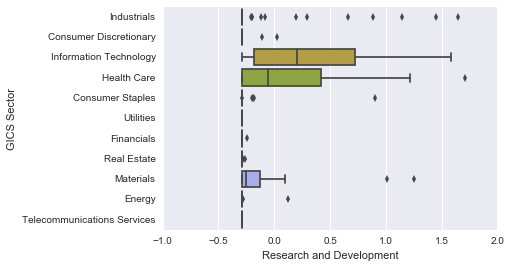

In [19]:
ax = sns.boxplot(y='GICS Sector', x="Research and Development", 
                 data=pd.concat([X, y], axis=1), orient='h')
plt.xlim(-1,2)

(-4, 2)

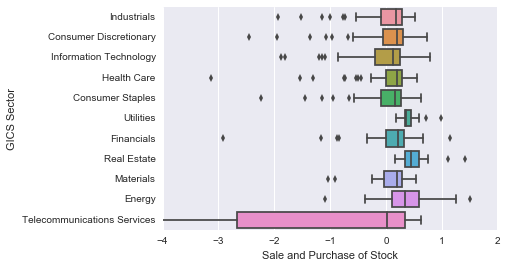

In [20]:
ax = sns.boxplot(y='GICS Sector', x="Sale and Purchase of Stock", 
                 data=pd.concat([X, y], axis=1), orient='h')

plt.xlim(-4,2)

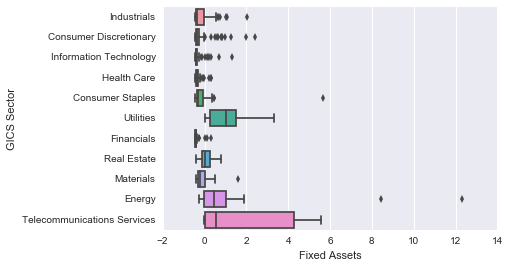

In [21]:
#Fixed Assets
ax = sns.boxplot(y='GICS Sector', x="Fixed Assets", 
                 data=pd.concat([X, y], axis=1), orient='h')

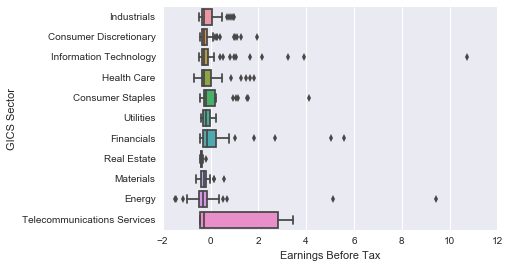

In [22]:
#Earnings Before Tax 
ax = sns.boxplot(y='GICS Sector', x="Earnings Before Tax", 
                 data=pd.concat([X, y], axis=1), orient='h')

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rf = RandomForestClassifier()
rf.fit(X, y)
rf.score(X, y)

0.9888392857142857

In [31]:
sorted(zip(X.columns, rf.feature_importances_), key=lambda x: -x[1])

[('Research and Development', 0.046908761307086946),
 ('Total Current Liabilities', 0.040402743439420255),
 ('Inventory', 0.033686421840449905),
 ('Sales, General and Admin.', 0.025612566766867122),
 ('Intangible Assets', 0.024807913842653774),
 ('Fixed Assets', 0.024041775568260648),
 ('Other Assets', 0.02395669230831806),
 ('Liabilities', 0.021814770632884756),
 ('Operating Margin', 0.021525238786506386),
 ('Long-Term Investments', 0.02081332598444547),
 ('Cost of Revenue', 0.0206195064049042),
 ('Other Equity', 0.020367571854406526),
 ('Other Investing Activities', 0.01950717279227834),
 ('Other Current Assets', 0.019363025420838981),
 ('Total Current Assets', 0.018964784093508429),
 ('Profit Margin', 0.017984016354534203),
 ('Deferred Liability Charges', 0.017564784196474222),
 ('Operating Income', 0.016258595971887883),
 ('Net Income', 0.016170924540799575),
 ('Short-Term Investments', 0.016151569311378188),
 ('Other Operating Items', 0.016084444047220196),
 ('Changes in Inventori

In [32]:
rf = RandomForestClassifier()

In [33]:
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [34]:
help(rf)

Help on RandomForestClassifier in module sklearn.ensemble.forest object:

class RandomForestClassifier(ForestClassifier)
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and use averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |      Note: this parameter is tree-specific.
 |  
 |  max_features : int, f